In [18]:
source = "./tool-tracking-data/"

In [19]:
from datatools import MeasurementDataReader
mdr = MeasurementDataReader(source=source)

In [20]:
from datatools import Tool

#mytool = "electric_screwdriver"
mytool = "pneumatic_screwdriver"

In [21]:
import numpy as np
from seglearn.base import TS_Data
from seglearn.pipe import Pype
from fhgutils import Segment, contextual_recarray_dtype, filter_ts_data
from datatools import to_ts_data


### 1. Raw extract windows

In [22]:
window_length=0.4 # unit in s
overlap = 0.5 # unit in percent

# clean and window data
data_dict = mdr.query().filter_by(Tool == mytool).get()
Xt, Xc, y = to_ts_data(data_dict, contextual_recarray_dtype)

X = TS_Data(Xt, Xc)
pipe = Pype([
    ('segment', Segment(window_length=window_length, overlap=overlap, enforce_size=True, n=len(np.unique(Xc.desc))))
])

print('###############################################')
print("Number of sequences:", len(X.ts_data))
for i, seq in enumerate(X.ts_data):
    print(f"Sequence {i}: Type = {type(seq)}, Shape = {np.shape(seq)}")


X_trans, y_trans = pipe.fit_transform(X, y)

[INFO] Preparing data from:
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724
  tool-tracking-data\pneumatic_screwdriver\iot_lab-03-20200724


[INFO] Read annotation: 100%|██████████| 16/16 [00:02<00:00,  6.05it/s, file=data-04.annotation]


[INFO] Finished with 4 measurement(s).
###############################################
Number of sequences: 16
Sequence 0: Type = <class 'numpy.ndarray'>, Shape = (34271, 4)
Sequence 1: Type = <class 'numpy.ndarray'>, Shape = (34271, 4)
Sequence 2: Type = <class 'numpy.ndarray'>, Shape = (51930, 4)
Sequence 3: Type = <class 'numpy.ndarray'>, Shape = (2680320, 2)
Sequence 4: Type = <class 'numpy.ndarray'>, Shape = (36314, 4)
Sequence 5: Type = <class 'numpy.ndarray'>, Shape = (36314, 4)
Sequence 6: Type = <class 'numpy.ndarray'>, Shape = (55093, 4)
Sequence 7: Type = <class 'numpy.ndarray'>, Shape = (2840000, 2)
Sequence 8: Type = <class 'numpy.ndarray'>, Shape = (29631, 4)
Sequence 9: Type = <class 'numpy.ndarray'>, Shape = (29631, 4)
Sequence 10: Type = <class 'numpy.ndarray'>, Shape = (44848, 4)
Sequence 11: Type = <class 'numpy.ndarray'>, Shape = (2317440, 2)
Sequence 12: Type = <class 'numpy.ndarray'>, Shape = (27080, 4)
Sequence 13: Type = <class 'numpy.ndarray'>, Shape = (27080, 

### To get the class and corresponding labels

In [23]:
print(data_dict["01"]["classes"])

{8: 'undefined', 3: 'untightening', 2: 'tightening', 14: 'tightening_double', 38: 'impact', 5: 'motor_activity_ccw', 7: 'shaking', 4: 'motor_activity_cw'}


In [24]:

print("[INFO] extract segmented ACC data")
Xt_acc, Xc_acc, y_acc = filter_ts_data(X_trans, y_trans, filt={'desc': ['acc']})

print("[INFO] extract segmented GYR data")
Xt_gyr, Xc_gyr, y_gyr = filter_ts_data(X_trans, y_trans, filt={'desc': ['gyr']})

print("[INFO] extract segmented MAG data")
Xt_mag, Xc_mag, y_mag = filter_ts_data(X_trans, y_trans, filt={'desc': ['mag']})

print("[INFO] extract segmented MIC data")
Xt_mic, Xc_mic, y_mic = filter_ts_data(X_trans, y_trans, filt={'desc': ['mic']})


[INFO] extract segmented ACC data
[INFO] extract segmented GYR data
[INFO] extract segmented MAG data
[INFO] extract segmented MIC data


In [25]:
print("[INFO] shape of ACC data is", Xt_acc.shape)
print("[INFO] shape of GYR data is", Xt_gyr.shape)
print("[INFO] shape of MAG data is", Xt_mag.shape)
print("[INFO] shape of MIC data is", Xt_mic.shape)
print(f"[INFO] {Xt_gyr.shape[0]} windows with {Xt_gyr[0].shape[0]} sample each (time stamps and 3 axis gyroscope)")
print(f"[INFO] {Xt_acc.shape[0]} windows with {Xt_acc[0].shape[0]} sample each (time stamps and 3 axis accelerometer)")
print(f"[INFO] {Xt_mag.shape[0]} windows with {Xt_mag[0].shape[0]} sample each (time stamps and 3 axis magnetometer)")
print(f"[INFO] {Xt_mic.shape[0]} windows with {Xt_mic[0].shape[0]} sample each (time stamps and 1 axis microphone)")

[INFO] shape of ACC data is (6217,)
[INFO] shape of GYR data is (6217,)
[INFO] shape of MAG data is (6217,)
[INFO] shape of MIC data is (6217,)
[INFO] 6217 windows with 41 sample each (time stamps and 3 axis gyroscope)
[INFO] 6217 windows with 41 sample each (time stamps and 3 axis accelerometer)
[INFO] 6217 windows with 62 sample each (time stamps and 3 axis magnetometer)
[INFO] 6217 windows with 3200 sample each (time stamps and 1 axis microphone)


### 2. Remove ambiguious windows

In [26]:
from fhgutils import one_label_per_window
from data_preprocessing import find_ambiguous_windows,remove_windows_by_indices

In [27]:
ambiguous_acc = find_ambiguous_windows(Xt_acc, Xc_acc, y_acc, name="ACC")
ambiguous_gyr = find_ambiguous_windows(Xt_gyr, Xc_gyr, y_gyr, name="GYR")
ambiguous_mag = find_ambiguous_windows(Xt_mag, Xc_mag, y_mag, name="MAG")
ambiguous_mic = find_ambiguous_windows(Xt_mic, Xc_mic, y_mic, name="MIC")

# Union of all ambiguous window indices - windows with no majority label
ambiguous_indices = set(ambiguous_acc) | set(ambiguous_gyr) | set(ambiguous_mag) | set(ambiguous_mic)

print(f"Number of all ambiguous window indices across 4 modalities: {len(ambiguous_indices)}")

# To remove windows without majority label from all modalities
Xt_acc_f, Xc_acc_f, y_acc_f = remove_windows_by_indices(Xt_acc, Xc_acc, y_acc, ambiguous_indices)
Xt_gyr_f, Xc_gyr_f, y_gyr_f = remove_windows_by_indices(Xt_gyr, Xc_gyr, y_gyr, ambiguous_indices)
Xt_mag_f, Xc_mag_f, y_mag_f = remove_windows_by_indices(Xt_mag, Xc_mag, y_mag, ambiguous_indices)
Xt_mic_f, Xc_mic_f, y_mic_f = remove_windows_by_indices(Xt_mic, Xc_mic, y_mic, ambiguous_indices)

# Code to print the window incase of unequal samples per window, eg: incase MIC data for pneumatic screw driver
for k in range(len(y_mic_f)):
    for i in y_mic_f[k]:
        if i == -42:
            print(k)


[ACC] Checking for ambiguous windows...
[ACC] Found 0 ambiguous windows.
[GYR] Checking for ambiguous windows...
[GYR] Found 0 ambiguous windows.
[MAG] Checking for ambiguous windows...
[MAG] Found 73 ambiguous windows.
[MIC] Checking for ambiguous windows...
[MIC] Found 34 ambiguous windows.
Number of all ambiguous window indices across 4 modalities: 84
[INFO] Xt shape: (6133,)
[INFO] y shape after processing: (6133, 41)
[INFO] Xt shape: (6133,)
[INFO] y shape after processing: (6133, 41)
[INFO] Xt shape: (6133,)
[INFO] y shape after processing: (6133, 62)
[INFO] Xt shape: (6133,)
[INFO] y shape after processing: (6133, 3200)
5495


### 3. Apply one label per window

In [28]:
y_acc_f = one_label_per_window(y_acc_f)
y_gyr_f = one_label_per_window(y_gyr_f)
y_mag_f = one_label_per_window(y_mag_f)
y_mic_f = one_label_per_window(y_mic_f)
# Print y_mic_f
print("-----------------------------------------------")
print(f"[ACC] Number of windows after removing ambiguous window indices: {len(y_acc_f)}")
print(f"[GYR] Number of windows after removing ambiguous window indices: {len(y_gyr_f)}")
print(f"[MAG] Number of windows after removing ambiguous window indices: {len(y_mag_f)}")
print(f"[MIC] Number of windows after removing ambiguous window indices: {len(y_mic_f)}")

inconsistent_indices = [
    i for i in range(len(y_acc_f))
    if not (y_acc_f[i] == y_gyr_f[i] == y_mag_f[i] == y_mic_f[i])
]
print(f"The number of mismatched windows before removing across 4 modalities: {len(inconsistent_indices)}")

Xt_acc_f, Xc_acc_f, y_acc_f = remove_windows_by_indices(Xt_acc_f, Xc_acc_f, y_acc_f, inconsistent_indices)
Xt_gyr_f, Xc_gyr_f, y_gyr_f = remove_windows_by_indices(Xt_gyr_f, Xc_gyr_f, y_gyr_f, inconsistent_indices)
Xt_mag_f, Xc_mag_f, y_mag_f = remove_windows_by_indices(Xt_mag_f, Xc_mag_f, y_mag_f, inconsistent_indices)
Xt_mic_f, Xc_mic_f, y_mic_f = remove_windows_by_indices(Xt_mic_f, Xc_mic_f, y_mic_f, inconsistent_indices)

inconsistent_indices = [
    i for i in range(len(y_acc_f))
    if not (y_acc_f[i] == y_gyr_f[i] == y_mag_f[i] == y_mic_f[i])
]
print(f"The number of mismatched windows after removing across 4 modalities (should be zero): {len(inconsistent_indices)}")

print("-----------------------------------------------")
print(f"[ACC] Number of windows after removing mismatched window indices: {len(y_acc_f)}")
print(f"[GYR] Number of windows after removing mismatched window indices: {len(y_gyr_f)}")
print(f"[MAG] Number of windows after removing mismatched window indices: {len(y_mag_f)}")
print(f"[MIC] Number of windows after removing mismatched window indices: {len(y_mic_f)}")



Below find the number of unique labels in the data
flattened 9 labels: [-1  2  3  4  5  7  8 14 38]
Below find the number of unique labels in the data
flattened 9 labels: [-1  2  3  4  5  7  8 14 38]
Below find the number of unique labels in the data
flattened 9 labels: [-1  2  3  4  5  7  8 14 38]
Below find the number of unique labels in the data
flattened 9 labels: [-1  2  3  4  5  7  8 14 38]
-----------------------------------------------
[ACC] Number of windows after removing ambiguous window indices: 6133
[GYR] Number of windows after removing ambiguous window indices: 6133
[MAG] Number of windows after removing ambiguous window indices: 6133
[MIC] Number of windows after removing ambiguous window indices: 6133
The number of mismatched windows before removing across 4 modalities: 9
[INFO] Xt shape: (6124,)
[INFO] y shape after processing: (6124,)
[INFO] Xt shape: (6124,)
[INFO] y shape after processing: (6124,)
[INFO] Xt shape: (6124,)
[INFO] y shape after processing: (6124,)
[I

In [29]:
# Verify that the number of windows and window length are consistent
print(f"[INFO] {Xt_acc_f.shape[0]} windows with {Xt_acc_f[0].shape[0]} sample each (time stamps and 3 axis accelerometer)")
print(f"[INFO] {Xt_gyr_f.shape[0]} windows with {Xt_gyr_f[0].shape[0]} sample each (time stamps and 3 axis gyroscope)")
print(f"[INFO] {Xt_mag_f.shape[0]} windows with {Xt_mag_f[0].shape[0]} sample each (time stamps and 3 axis magnetometer)")
print(f"[INFO] {Xt_mic_f.shape[0]} windows with {Xt_mic_f[0].shape[0]} sample each (time stamps and 1 axis microphone)")


[INFO] 6124 windows with 41 sample each (time stamps and 3 axis accelerometer)
[INFO] 6124 windows with 41 sample each (time stamps and 3 axis gyroscope)
[INFO] 6124 windows with 62 sample each (time stamps and 3 axis magnetometer)
[INFO] 6124 windows with 3200 sample each (time stamps and 1 axis microphone)


### 4. Interpolation + Timestamp-aligned Downsampling + MFCC for audio features

In [31]:
import numpy as np
from scipy.interpolate import interp1d
import librosa
import pandas as pd

combined_data = []
combined_labels = []

target_length = 41
n_mfcc = 13  # Typical choice
num_windows = Xt_acc_f.shape[0]  # Number of windows after filtering
y_filtered = y_acc_f  # Assuming y_acc_f is representative of the labels

for i in range(num_windows):
    time_acc = Xt_acc_f[i][:, 0]
    acc_values = Xt_acc_f[i][:, 1:]

    time_gyr = Xt_gyr_f[i][:, 0]
    gyr_values = Xt_gyr_f[i][:, 1:]

    time_mag = Xt_mag_f[i][:, 0]
    mag_values = Xt_mag_f[i][:, 1:]

    time_mic = Xt_mic_f[i][:, 0]
    mic_values = Xt_mic_f[i][:, 1]

    reference_time = time_acc

    def safe_interp(original_time, values, target_time, num_axes=1):
        try:
            if num_axes == 1:
                f = interp1d(original_time, values, bounds_error=False, fill_value="extrapolate")
                return f(target_time).reshape(-1, 1)
            else:
                return np.stack([
                    interp1d(original_time, values[:, j], bounds_error=False, fill_value="extrapolate")(target_time)
                    for j in range(num_axes)
                ], axis=-1)
        except Exception as e:
            print(f"[WARN] Interpolation failed at window {i}: {e}")
            return np.full((len(target_time), num_axes), np.nan)

    acc_interp = acc_values  # already aligned
    gyr_interp = safe_interp(time_gyr, gyr_values, reference_time, 3)
    mag_interp = safe_interp(time_mag, mag_values, reference_time, 3)

    # Process MIC to MFCC
    try:
        mic_signal = mic_values.astype(np.float32)

        # Compute MFCC
        sr = 16000  # or estimated sampling rate
        hop_length = len(mic_signal) // target_length
        mfcc = librosa.feature.mfcc(y=mic_signal, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)

        mfcc = mfcc.T  # Transpose to shape (41, 13)
        if mfcc.shape[0] < target_length:
            # Pad if short
            mfcc = np.pad(mfcc, ((0, target_length - mfcc.shape[0]), (0, 0)), mode='constant')
        elif mfcc.shape[0] > target_length:
            mfcc = mfcc[:target_length]
    except Exception as e:
        print(f"[WARN] MFCC extraction failed at window {i}: {e}")
        mfcc = np.zeros((target_length, n_mfcc))

    # Combine all
    aligned = np.concatenate([acc_interp, gyr_interp, mag_interp, mfcc], axis=1)  # shape: (41, 22)
    combined_data.append(aligned)
    combined_labels.append(y_filtered[i])

combined_data = np.array(combined_data)  # shape: (7141, 41, 22)
combined_labels = np.array(combined_labels)


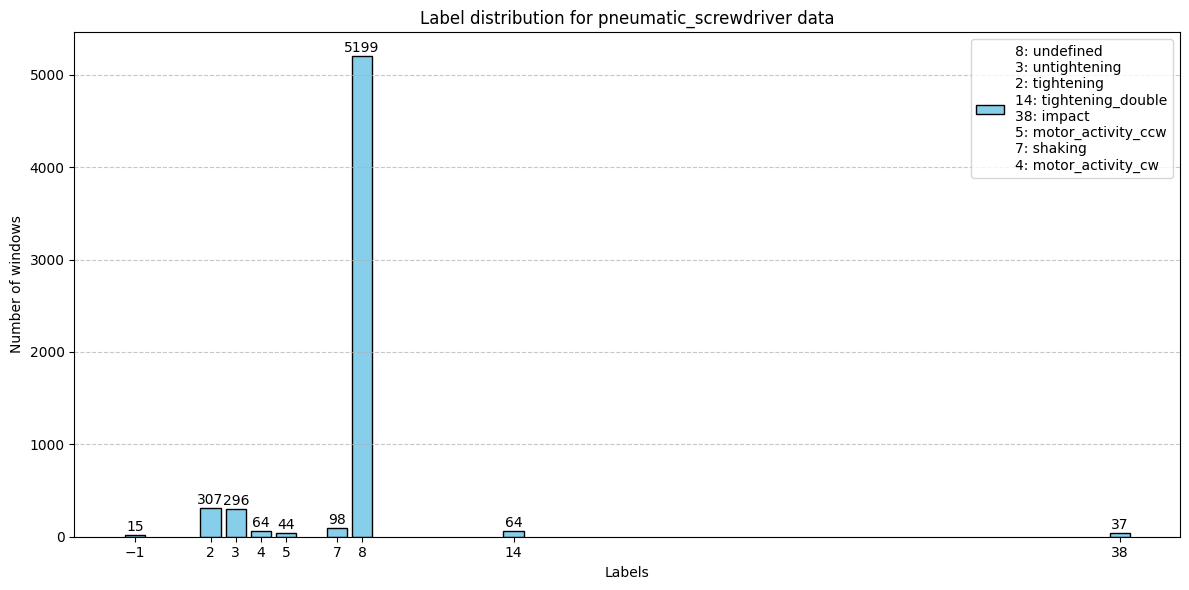

In [32]:
import matplotlib.pyplot as plt

# Use dynamic label mapping from data_dict
label_names = data_dict["01"]["classes"]

# Get unique labels and their counts
unique_labels, counts = np.unique(y_mic_f, return_counts=True)

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(unique_labels, counts, color='skyblue', edgecolor='black')

# Add annotations (counts) above each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, str(count), 
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Labels')
plt.ylabel('Number of windows')
plt.title(f'Label distribution for {mytool} data')
plt.xticks(unique_labels)

# Dynamically create legend entries from label_names
legend_entries = [f"{k}: {v}" for k, v in label_names.items()]
legend_text = '\n'.join(legend_entries)

# Add legend box with class descriptions
plt.gca().legend([legend_text], loc='upper right', frameon=True, fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 5. Save the features and labels

In [33]:
# Verify the shapes 

print("combined_data shape:", combined_data.shape)  # Should be (7141, 41, 22)
print("combined_labels shape:", combined_labels.shape)  # Should be (7141,)
print("Example data shape:", combined_data[0].shape)  # Should be (41, 22)
print("Example label:", combined_labels[0])  # Should be a single label

# Save the combined data and labels into train and test sets
import numpy as np
import os
output_dir = "./processed_data/"
os.makedirs(output_dir, exist_ok=True)

if mytool == "eletric_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        6: 'manual_motor_rotation',
        7: 'shaking',
        14: 'tightening_double'
    }
elif mytool == "pneumatic_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        7: 'shaking',
        14: 'tightening_double',
        38: 'impact'
    }


# Filter out invalid labels
valid_labels = list(label_info.keys())
valid_indices = np.isin(combined_labels, valid_labels)
X = combined_data[valid_indices]
y = combined_labels[valid_indices]


# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Save the train and test sets
np.save(os.path.join(output_dir, f"combined_data_train_{mytool}.npy"), X_train)
np.save(os.path.join(output_dir, f"combined_label_train_{mytool}.npy"), y_train)
np.save(os.path.join(output_dir, f"combined_data_test_{mytool}.npy"), X_test)
np.save(os.path.join(output_dir, f"combined_label_test_{mytool}.npy"), y_test)

print("[INFO] Data processing complete. Train and test sets saved.")
print("Train set shapes:", X_train.shape, y_train.shape)
print("Test set shapes:", X_test.shape, y_test.shape)
print("[INFO] Processed data saved in:", output_dir)

combined_data shape: (6124, 41, 22)
combined_labels shape: (6124,)
Example data shape: (41, 22)
Example label: 8
[INFO] Data processing complete. Train and test sets saved.
Train set shapes: (728, 41, 22) (728,)
Test set shapes: (182, 41, 22) (182,)
[INFO] Processed data saved in: ./processed_data/
